In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-failure-prediction/heart.csv


# 1.Data exploration and getting insights

In [2]:
data = pd.read_csv('../input/heart-failure-prediction/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
#Checking Dtypes
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [4]:
#Checking MissingValues
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
categorical_features=['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']
numerical_features= ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
target = ['HeartDisease']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


avg age = 54
avg age of disiease = 56


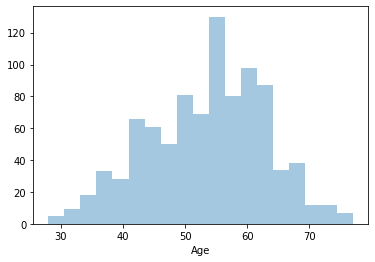

In [6]:
sns.distplot(a=data['Age'], kde=False)

avg_age = round(data['Age'].mean())

avg_heart_disease_age = round(data.loc[data["HeartDisease"]>0].Age.mean())

print(f'avg age = {avg_age}\navg age of disiease = {avg_heart_disease_age}')

Number of males = 725
Number of Females = 193

        
Number of affected males = 458
Number of affected females = 50

        
% of Male with disease= 63.17%
% of Female with disease= 25.91%



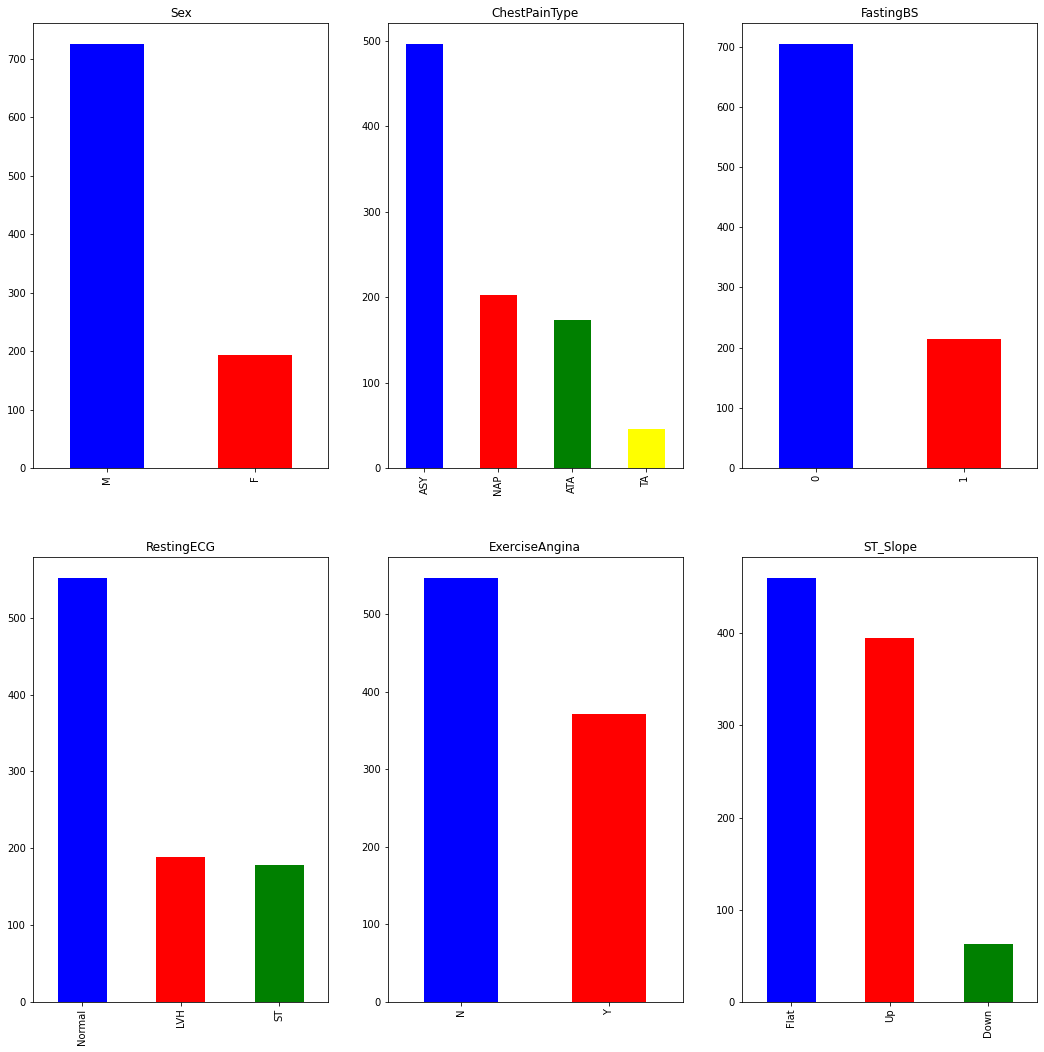

In [7]:
male = data.loc[data['Sex']=='M']
female = data.loc[data['Sex']=='F']

n_male = len(male)
n_female = len(female)

n_male_disease = len(male.loc[male["HeartDisease"]>0])
n_female_disease = len(female.loc[female["HeartDisease"]>0])

print(f'''Number of males = {n_male}\nNumber of Females = {n_female}\n
        \nNumber of affected males = {n_male_disease}\nNumber of affected females = {n_female_disease}\n
        \n% of Male with disease= {round(n_male_disease/n_male,4)*100}%\n% of Female with disease= {round(n_female_disease/n_female,4)*100}%\n''')

ROWS, COLS = 2, 3
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    data[categorical_feature].value_counts().plot(kind='bar', ax=ax[row, col],color=['blue', 'red', 'green', 'yellow']).set_title(categorical_feature)




The data set it's not balanced.
* There are more male samples than female, about 60% of males have a heart disease while about 25% of females do.
* There are significaly more cases of ASY chestpain types than the other three and very few of TA chestpain
* There are more samples of people that didn't do fasting.
* There are more people with normal RestingECG , but more or less the same amounts of the other two types.
* There are more people that didn't Excercise angina
* There is a significant lack of down ST_Slope values 

In [8]:
data[numerical_features].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


<AxesSubplot:>

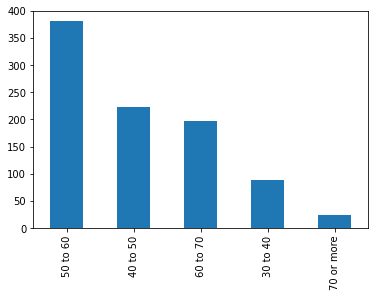

In [9]:
#Age group might be more usefull than age later on,dataset ages go up to 77 years old so I'll call the last category 70 or more in case the model recibes data from an 80+ patient.
data['Age_group'] = pd.cut(x=data['Age'], bins=[30, 40, 50, 60, 70, 80],
                            labels=['30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 or more'])

data['Age_group'].value_counts().plot(kind='bar')

Most of the samples age are around 50-60 years old

<AxesSubplot:>

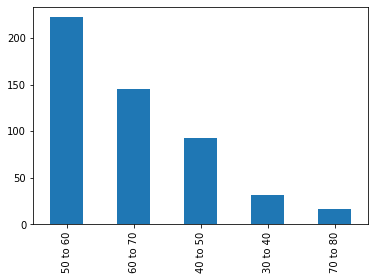

In [10]:
#Seeing how many of each group got a heath disease
pd.cut(x=data.loc[data["HeartDisease"]>0].Age, bins=[30, 40, 50, 60, 70, 80],
        labels=['30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80']).value_counts().plot(kind='bar')

From this graph we can get that people around 50 to 70 years old are more propense into haveing a hearth disease

array([<AxesSubplot:title={'center':'Age'}>,
       <AxesSubplot:title={'center':'RestingBP'}>,
       <AxesSubplot:title={'center':'Cholesterol'}>,
       <AxesSubplot:title={'center':'MaxHR'}>,
       <AxesSubplot:title={'center':'Oldpeak'}>], dtype=object)

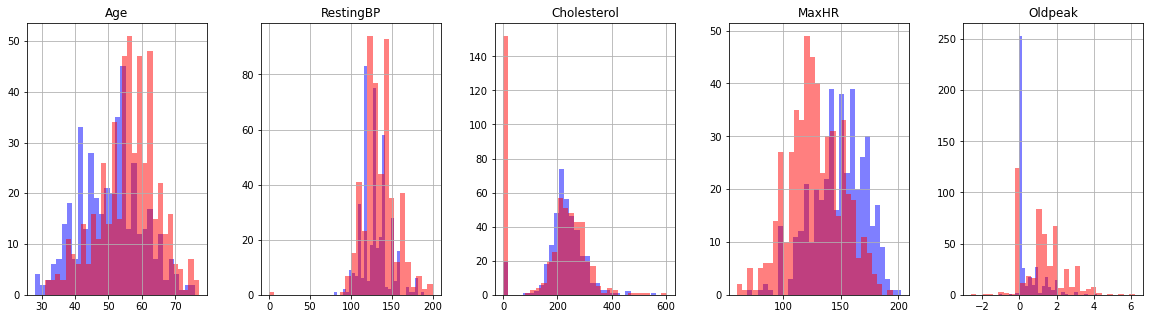

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
data[data["HeartDisease"]<1][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
data[data["HeartDisease"]>0][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

#### The blue color represents people who didn't got a hearth disease while red represents the oposite.
* People with a Max HearthRate bellow 150 were more likely to have a hearth disease
* Almost all people with an oldpeak diferent than 0 ,the further away from 0 the less likely to find people that didn't have a hearth disease.
* People who had Unhealthy levels of cholesterol (around 125-200 are the healthy levels of total cholesterol for adults) got higher chances of haveing a hearth disease, it seems most of them were with 0 cholesterol in this dataset.
* People with a higher blood resting pressure got higher chances of getting a hearth disease(specially the ones that got between ~110-140), there are one or two with 0 blood pressure which basicaly means that the person should be dead so I might drop that ones.
* As for age it was discussed on previous cells. People of ages 50-70 were more propence to have a heath disease.